In [4]:
import os, joblib, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
OUTDIR = "data/task4output"
MODELDIR = "models"
PRIORITIZED_CSV = os.path.join(OUTDIR, "/content/prioritized_testcases_xgb.csv")
FI_CSV = os.path.join(OUTDIR, "feature_importance.csv")
MODEL_JSON = os.path.join(MODELDIR, "xgb_model.json")
sns.set(style="whitegrid")


In [5]:
df = pd.read_csv(PRIORITIZED_CSV)
print("rows:", len(df))
df.head()


rows: 8605


,filename,dut,dut_version,os_version,config,test_case,line_number,timestamp,run_date,status,...,regression_group,schedule_cycle,past_failure_frequency,isFail,pred_prob,recency_weight,cluster_fail_rate,cluster_weight,priority_score,priority_group
0,tc_conf_udp_hvg_003_20241001-174511.log,Dinstar,1.2,Linux,udp_check,tc_conf_udp_hvg_003,546,2024-10-01 17:46:35.993,2024-10-01,FAIL,...,56,94,54,1,0.999866,5.999833,1.0,3.0,17.997093,HIGH RISK
1,tc_conf_udp_hvg_003_20240930-192307.log,Dinstar,1.2,Linux,copy_of_dtmf_test_mgw,tc_conf_udp_hvg_003,566,2024-09-30 19:23:30.078,2024-09-30,FAIL,...,56,62,41,1,0.999858,5.999833,1.0,3.0,17.996953,HIGH RISK
2,tc_conf_udp_hvg_003_20240930-165228.log,Dinstar,1.2,Linux,copy_of_dtmf_test_mgw,tc_conf_udp_hvg_003,739,2024-09-30 16:53:29.593,2024-09-30,FAIL,...,56,59,38,1,0.999858,5.999833,1.0,3.0,17.996953,HIGH RISK
3,tc_conf_udp_hvg_003_20240930-162411.log,Dinstar,1.2,Linux,dtmf_test_mgw,tc_conf_udp_hvg_003,562,2024-09-30 16:24:54.685,2024-09-30,FAIL,...,56,37,18,1,0.999854,5.999833,1.0,3.0,17.996865,HIGH RISK
4,tc_conf_udp_hvg_003_20240930-165122.log,Dinstar,1.2,Linux,copy_of_dtmf_test_mgw,tc_conf_udp_hvg_003,722,2024-09-30 16:51:53.668,2024-09-30,FAIL,...,56,56,35,1,0.999854,5.999833,1.0,3.0,17.996865,HIGH RISK


In [6]:
# If you saved testset predictions, load them; otherwise compute simple metrics using 'isFail' and pred_prob
if "pred_prob" in df.columns and "isFail" in df.columns:
    y_true = df["isFail"]
    y_prob = df["pred_prob"]
    y_pred = (y_prob >= 0.5).astype(int)
    print("Precision", precision_score(y_true, y_pred))
    print("Recall", recall_score(y_true, y_pred))
    print("F1", f1_score(y_true, y_pred))
    print("ROC-AUC", roc_auc_score(y_true, y_prob))
else:
    print("pred_prob or isFail missing in CSV; run evaluation on testset separately.")


Precision 1.0
Recall 1.0
F1 1.0
ROC-AUC 0.9999999999999999


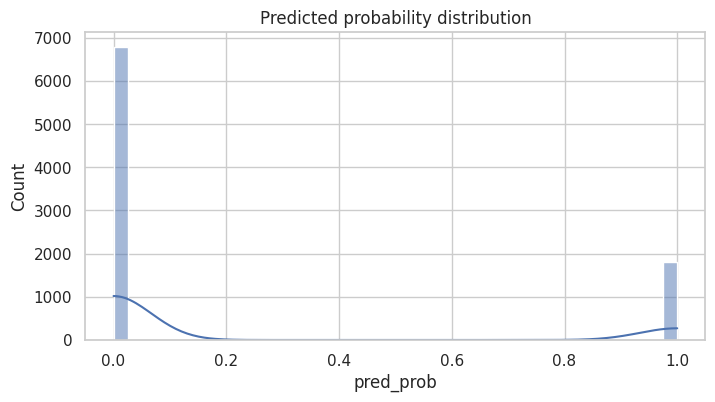

/tmp/ipython-input-1331110214.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Reds_d")


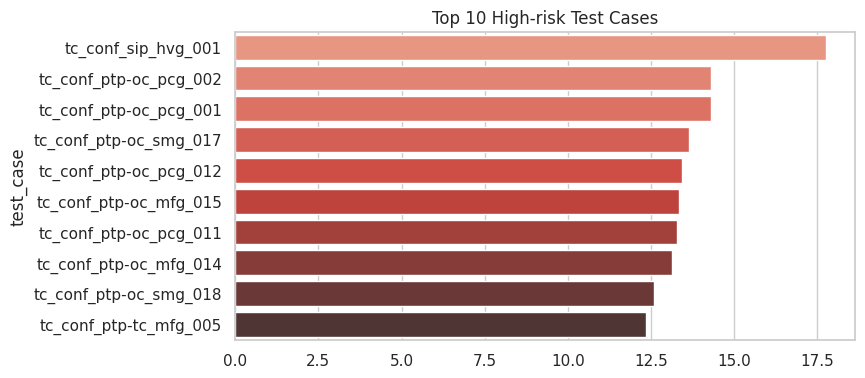

In [7]:
plt.figure(figsize=(8,4))
if "pred_prob" in df.columns:
    sns.histplot(df["pred_prob"], bins=40, kde=True)
    plt.title("Predicted probability distribution")
plt.show()

# Top 10 high risk
tc_col = "test_case" if "test_case" in df.columns else "test_case_id"
if tc_col in df.columns:
    top10 = df.groupby(tc_col)["priority_score"].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top10.values, y=top10.index, palette="Reds_d")
    plt.title("Top 10 High-risk Test Cases")
    plt.show()


In [9]:
out = pd.DataFrame()
out["test_case"] = df[tc_col] if tc_col in df.columns else df.index.astype(str)
out["predicted_probability"] = df["pred_prob"]
q_high = df["priority_score"].quantile(0.90)
q_med = df["priority_score"].quantile(0.60)
out["risk_level"] = out["predicted_probability"].apply(lambda p: "HIGH" if p>q_high else ("MEDIUM" if p>q_med else "LOW"))
out.to_csv(os.path.join(OUTDIR, "/content/prioritized_testcases_xgb.csv"), index=False)
print("Saved ->", os.path.join(OUTDIR, "/content/prioritized_testcases_xgb.csv"))
out.head()


Saved -> /content/prioritized_testcases_xgb.csv


,test_case,predicted_probability,risk_level
0,tc_conf_udp_hvg_003,0.999866,MEDIUM
1,tc_conf_udp_hvg_003,0.999858,MEDIUM
2,tc_conf_udp_hvg_003,0.999858,MEDIUM
3,tc_conf_udp_hvg_003,0.999854,MEDIUM
4,tc_conf_udp_hvg_003,0.999854,MEDIUM
